### Google Earth Engine meets Geopandas
**Author:** René Kopeinig<br>
**Description:** Extracting Landsat 8 TOA and CHIRPS precipitation data from Google Earth Engine and use Geopandas capabilities to create time series analysis. Furthermore, data will be visualized through a time series viewer and also a heat map.

In [13]:
%matplotlib inline

In [14]:
import ee, datetime, folium
import pandas as pd
from IPython.display import Image
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from folium.plugins import HeatMap
ee.Initialize()

### Create random point grid from shapefile
Our area of interest is the Mexican state Chiapas. We only going to create two points per polygon. By increasing this number, the computation time on retrieving information through Google Earth Engine will increase. 

In [15]:
chiapas = gpd.read_file('data/chiapas/chiapas.shp')
X = chiapas.to_crs({'init': 'epsg:4326'})

In [16]:
def get_random_points(X):
    n = 1
    x_min, y_min, x_max, y_max = X.bounds

    x = np.random.uniform(x_min, x_max, n)
    y = np.random.uniform(y_min, y_max, n)

    gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))
    gdf_points = gdf_points[gdf_points.within(X)]
    
    return gdf_points

x_list = []
for index, row in X.iterrows():
    x = gpd.GeoDataFrame({'CVE_MUN':row['CVE_MUN'],
                          'CVE_ENT':row['CVE_ENT'],
                          'NOM_MUN':row['NOM_MUN'],
                          'OID':row['OID'],
                      'geometry':get_random_points(row['geometry'])})
    x_list.append(x)
Y = pd.concat(x_list)

**Note:** Next Step takes between 5 and 30 minutes depending on our choice of random points per polygon. If you would like to avoid this step, continue with importing points file in data folder. <br><br> **Continue two code cells below!**

### Retrieve Landsat 8 TOA and CHIRPS Precipitation Data from Google Earth Engine
Data will be also reshaped after retrieve. This step might take up to 8 minutes if your random point per polygon is set to 2. To be fair, the sample size is rather small for the analysis. I'd recommend to use the CSV File named **points.csv**.

In [57]:
# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2019, 5, 25)

# Create image collection
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate(startTime, endTime)
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(startTime, endTime)

def _getInfo(image_collection, point):
    return image_collection.getRegion(point,500).getInfo()

def get_ndvi(x,point, row):
    header = x[0]
    data = array(x[1:])
    
    iTime = header.index('time')
    time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

    # List of used image bands
    band_list = ['B5',u'B4']

    iBands = [header.index(b) for b in band_list]
    yData = data[0:,iBands].astype(np.float)
 
    # Calculate NDVI
    red = yData[:,0]
    nir = yData[:,1]
    ndvi = (nir - red) / (nir + red)

    # Reshape NDVI array into Pandas Dataframe
    df = pd.DataFrame(data = ndvi*-1, index = time, columns = ['ndvi'])
    df_red = pd.DataFrame(data = red, index = time, columns = ['red'])
    l8_time_series = df.dropna()

    # Resampling
    monthly_landsat = l8_time_series.resample('M', how = 'mean')
    monthly_landsat['landsat_id'] = str(data[0][0])
    monthly_landsat['x'] = point['coordinates'][0]
    monthly_landsat['y'] = point['coordinates'][1]
    monthly_landsat['CVE_MUN'] = row['CVE_MUN']
    monthly_landsat['CVE_ENT'] = row['CVE_ENT']
    monthly_landsat['NOM_MUN'] = row['NOM_MUN']
    monthly_landsat['OID'] = row['OID']
    return monthly_landsat


def get_precipitation(x,point,row):
    # Reshape Chirps precipitation data 
    header = x[0]
    data = array(x[1:])
    iTime = header.index('time')
    time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

    band_list = ['precipitation']
    iBands = [header.index(b) for b in band_list]
    chirps = data[0:,iBands].astype(np.float)

    df = pd.DataFrame(data = chirps, index = time, columns = ['precipitation'])
    chirps_time_series = df.dropna()

    # Resampling
    monthly_chirps = chirps_time_series.resample('M', how = 'mean')
    monthly_chirps['chirps_id'] = str(data[0][0])
    monthly_chirps['x'] = point['coordinates'][0]
    monthly_chirps['y'] = point['coordinates'][1]
    monthly_chirps['CVE_MUN'] = row['CVE_MUN']
    monthly_chirps['CVE_ENT'] = row['CVE_ENT']
    monthly_chirps['NOM_MUN'] = row['NOM_MUN']
    monthly_chirps['OID'] = row['OID']
    return monthly_chirps


start_time = datetime.datetime.now()

l8_list = []
pp_list = []
for index , row in Y.iterrows():
    point = {'type':'Point', 'coordinates':[row['geometry'].x,row['geometry'].y]};
    _x = _getInfo(l8, point)
    _y = _getInfo(precipitation, point)
    l8_list.append(get_ndvi(_x,point,row))
    pp_list.append(get_precipitation(_y,point,row))

df_l8 = pd.concat(l8_list)
df_l8 = df_l8.reset_index()

df_pp = pd.concat(pp_list)
df_pp = df_pp.reset_index()

pp = df_pp.copy()
pp = df_pp[df_pp['index']>'2013-07-01']

ll8 = df_l8.copy()
ll8 = df_l8[df_l8['index']>'2013-07-01']

df = pd.merge(pp,ll8, on = ['index','CVE_MUN','CVE_ENT','NOM_MUN','OID','x','y'])
# df.to_csv('data/chiapas/points.csv',index=False)

end_time = datetime.datetime.now()
print('\nTotal run time:', end_time - start_time, '\n')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()



Total run time: 0:03:43.564132 



**Note:**
Instead of waiting 5 to 30 minutes (depends on variable n), load points file with 554 points.

In [17]:
df = pd.read_csv('data/chiapas/points.csv')

### Convert Pandas to GeoPandas DataFrame

In [18]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.y, df.x))
gdf = gdf.drop(columns=['x','y'])

In [19]:
dates = gdf['index'].unique()
time_series_list = []
for i in dates:
    time_series_list.append((gdf[gdf['index']==i].set_index(['NOM_MUN','index']).groupby(level=[0,1]).mean()))

df_time_series = pd.concat(time_series_list).reset_index()
df_time_series = df_time_series.merge(X[['geometry','NOM_MUN']])

gdf_time_series = gpd.GeoDataFrame(df_time_series)
gdf_time_series['index'] = pd.to_datetime(gdf_time_series['index'])

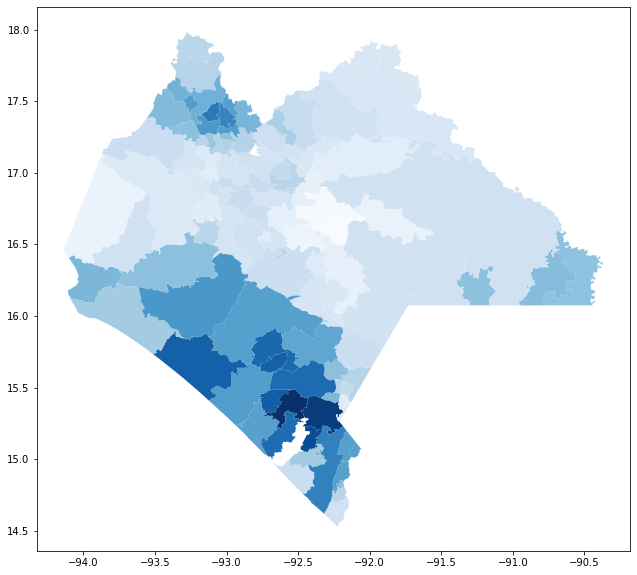

In [20]:
fig, ax = plt.subplots(figsize = (12,10), subplot_kw = {'aspect':'equal'})
gdf_time_series[gdf_time_series['index']=='2013-07-31'].plot(column = 'precipitation',cmap = 'Blues',ax = ax)

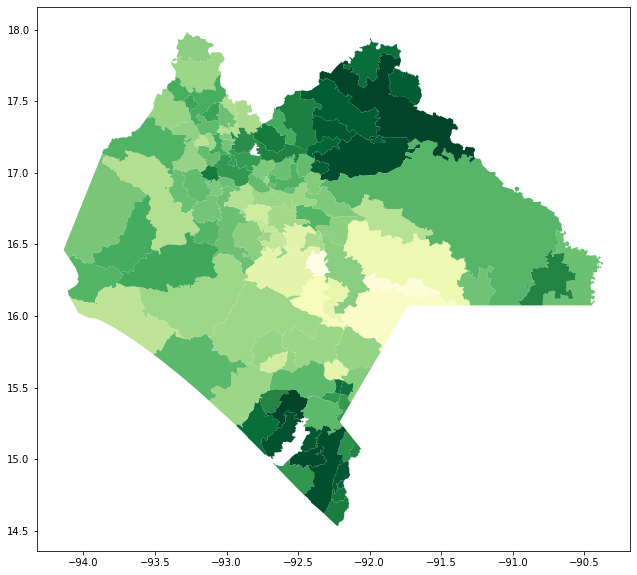

In [21]:
fig, ax = plt.subplots(figsize = (12,10), subplot_kw = {'aspect':'equal'})
gdf_time_series[gdf_time_series['index']=='2013-07-31'].plot(column = 'ndvi',cmap = 'YlGn',ax = ax)

### Create Time Series Viewer
In this last part, we are going to use widgets to browse through the Time-Series in order to see all time steps.

In [22]:
from IPython.display import display, clear_output
import ipywidgets as widgets


drop_dfu = widgets.Dropdown(options=sorted(gdf_time_series['index'].unique()), description='Choose Date:', 
                            disabled=False,layout={'width': 'max-content'})
display(drop_dfu)

def c(i):
    vmin, vmax = gdf_time_series['precipitation'].min(), gdf_time_series['precipitation'].max()

    fig,ax = plt.subplots(1,2,figsize=(25,15),subplot_kw={'aspect':'equal'})
    
    gdf_time_series[gdf_time_series['index']==drop_dfu.value].plot(column='ndvi',cmap='YlGn',ax=ax[0])
    gdf_time_series[gdf_time_series['index']==drop_dfu.value].plot(column='precipitation',cmap='Blues',ax=ax[1])
    
    for i in range(2):
        ax[i].axis('off')
        ax[i].set_title(["ndvi","precipitation"][i], fontsize=20)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(drop_dfu)
        c(drop_dfu.value)

drop_dfu.observe(on_change)

Dropdown(description='Choose Date:', layout=Layout(width='max-content'), options=(numpy.datetime64('2013-07-31…

### Precipitation Heat Map
Create a precipitation heat map on average precipitation values throughout the whole time series. 

In [23]:
points_gdf = gdf_time_series.copy()
points_gdf['x'] = points_gdf.centroid.x
points_gdf['y'] = points_gdf.centroid.y
precipitation = points_gdf.set_index('NOM_MUN')[['index','precipitation']].groupby(level=0).mean()
points_gdf = points_gdf[['NOM_MUN','x','y']].drop_duplicates()
points_gdf['precipitation']=precipitation.values

points_gdf = points_gdf[points_gdf['precipitation']>25]
points_array = points_gdf[['y', 'x']].values

m = folium.Map(location = [16.25, -92.45], tiles = 'stamentoner', zoom_start = 7, control_scale = True)
HeatMap(points_array).add_to(m)
m

### NDVI Heat Map
Create a NDVI heat map on average NDVI values throughout the whole time series. 

In [24]:
points_gdf = gdf_time_series.copy()
points_gdf['x'] = points_gdf.centroid.x
points_gdf['y'] = points_gdf.centroid.y
ndvi = points_gdf.set_index('NOM_MUN')[['index','ndvi']].groupby(level=0).mean()
points_gdf = points_gdf[['NOM_MUN','x','y']].drop_duplicates()
points_gdf['ndvi'] = ndvi.values

points_gdf = points_gdf[points_gdf['ndvi']>0.25]
points_array = points_gdf[['y', 'x']].values

m = folium.Map(location = [16.25, -92.45], tiles = 'stamentoner', zoom_start = 7, control_scale = True)
HeatMap(points_array).add_to(m)
m

### Forecast

In [25]:
from fbprophet import Prophet

In [49]:
df_x = gdf_time_series.copy()
df_x['precipitation_change']=df_x['precipitation'].pct_change(12)*100
df_x['ndvi_change']=df_x['ndvi'].pct_change(12)*100
df_x = df_x.fillna(0)

def create_prophet_df(x, field):
    x['ds']=x['index']
    x=x.set_index(['NOM_MUN','index'])
    x['y']=x[field]
    return x

def _forecast(x, indices, periods, freq):
    fcst=[]
    for i in indices:
        _dataframe=x.loc[i]
        m = Prophet()
        m.add_regressor('precipitation_change')
        m.add_regressor('ndvi_change')
        m.fit(_dataframe)
        
        future = m.make_future_dataframe(periods=periods, freq=freq, include_history=False)
        future['precipitation_change'] = 0
        future['ndvi_change'] = 0
        forecast=m.predict(future)[['yhat','ds']]
        forecast['NOM_MUN'] = i


        
        fcst.append(forecast)
    return pd.concat(fcst)

def forecast(dataframe, item):
    x = create_prophet_df(dataframe,item)
    forecast =_forecast(x, dataframe.NOM_MUN.unique(), 5, 'M')
    forecast = forecast.merge(dataframe[['NOM_MUN','geometry']].drop_duplicates('NOM_MUN'))
    forecast.columns = [item, 'Date', 'NOM_MUN', 'geometry']
    return forecast

In [50]:
gdf_forecast_precipitation = forecast(df_x,'precipitation')
gdf_forecast_ndvi = forecast(df_x,'ndvi')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [56]:
gdf_forecast_final=gpd.GeoDataFrame(gdf_forecast_ndvi.merge(gdf_forecast_precipitation[['NOM_MUN','Date','precipitation']]))

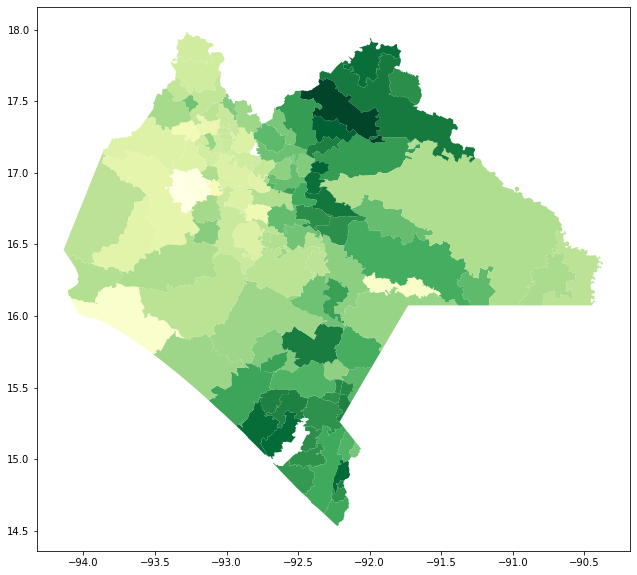

In [64]:
fig, ax = plt.subplots(figsize = (12,10), subplot_kw = {'aspect':'equal'})
gdf_forecast_final[gdf_forecast_final['Date']=='2019-07-31'].plot(column = 'ndvi',cmap = 'YlGn',ax = ax)